In [9]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

import joblib
import os

In [10]:
# Load dataset
df = pd.read_csv("Hotel Reservations.csv")
print("Shape:", df.shape)
df.head()

Shape: (36275, 19)


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [11]:
# Data dictionary mapping (short version)
data_dict = {
    "lead_time": "Days between booking & arrival",
    "avg_price_per_room": "Average room price per night",
    "no_of_special_requests": "Number of special requests",
    "booking_status": "Reservation status (Canceled/Not_Canceled)",
}
print("Sample Data Dictionary:", data_dict)

Sample Data Dictionary: {'lead_time': 'Days between booking & arrival', 'avg_price_per_room': 'Average room price per night', 'no_of_special_requests': 'Number of special requests', 'booking_status': 'Reservation status (Canceled/Not_Canceled)'}


In [12]:
# Missing values
df.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

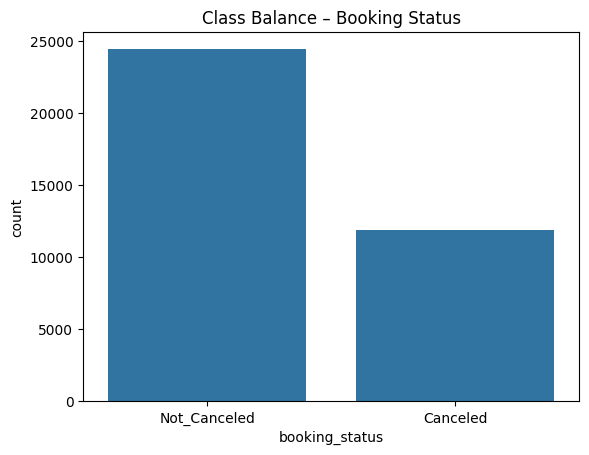

In [13]:
# Class balance
sns.countplot(x="booking_status", data=df)
plt.title("Class Balance – Booking Status")
plt.show()

In [14]:
# Drop Booking_ID (not useful for modeling)
df = df.drop(columns=['Booking_ID'])

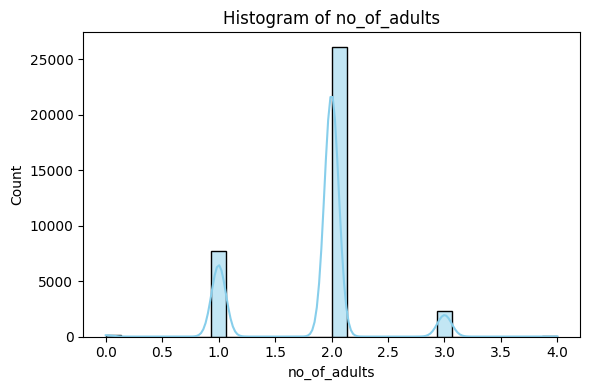

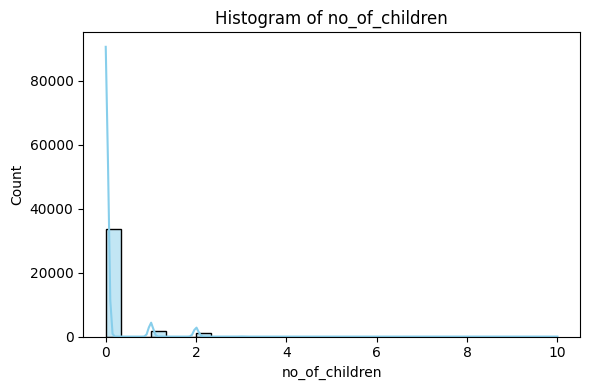

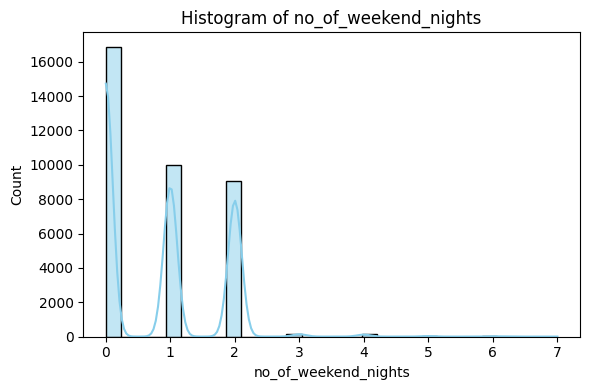

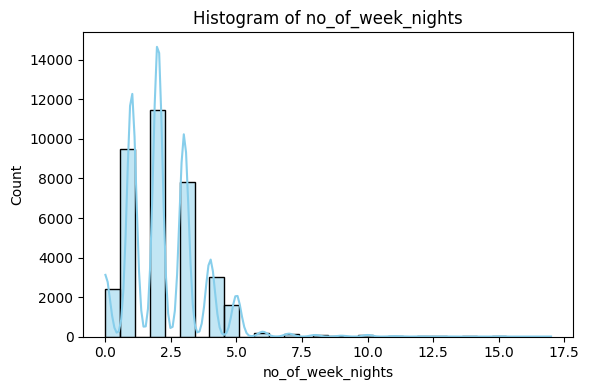

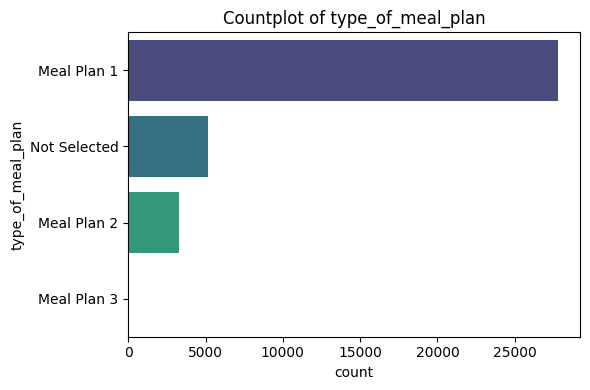

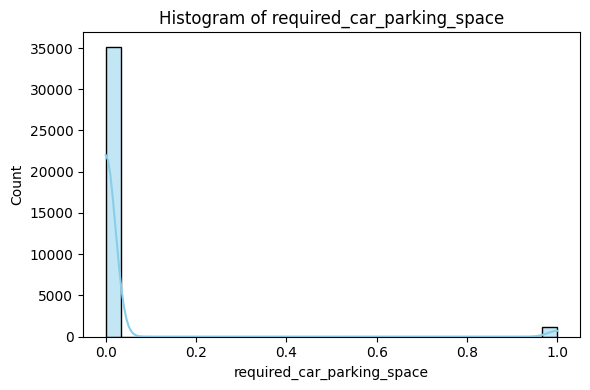

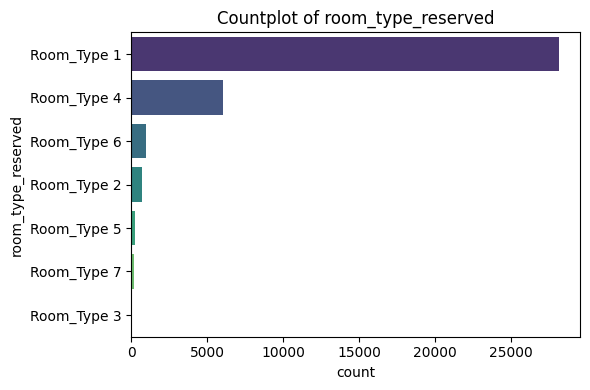

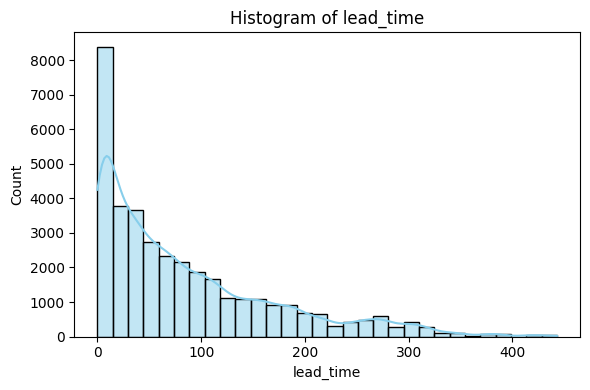

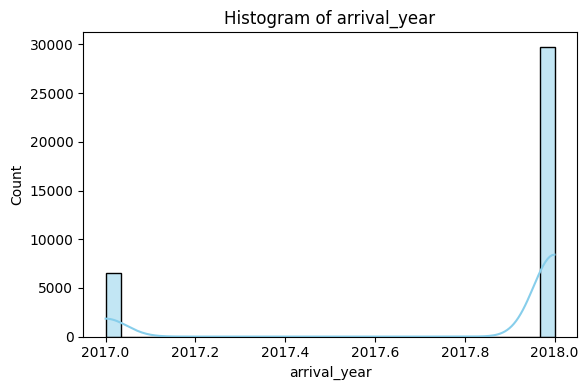

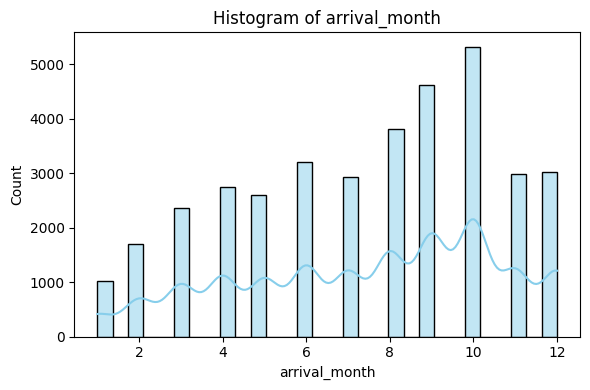

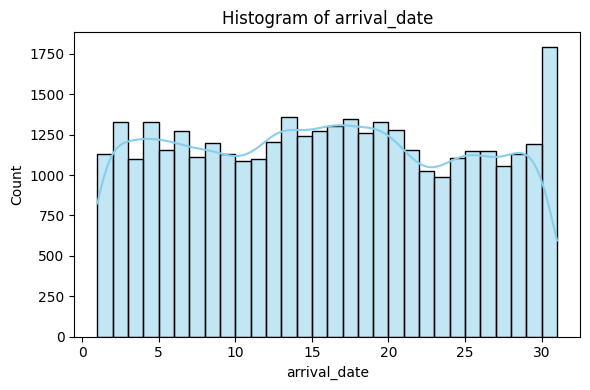

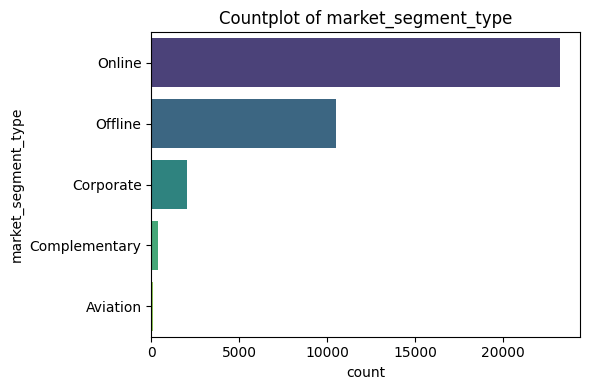

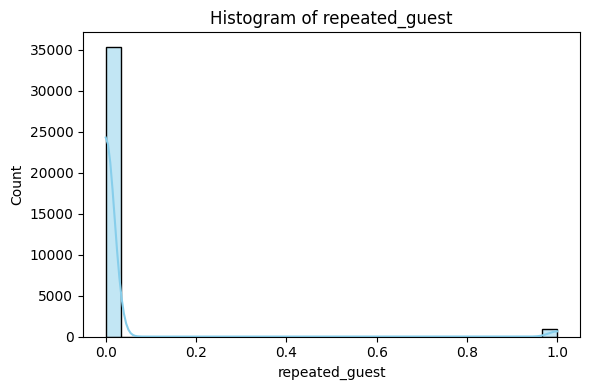

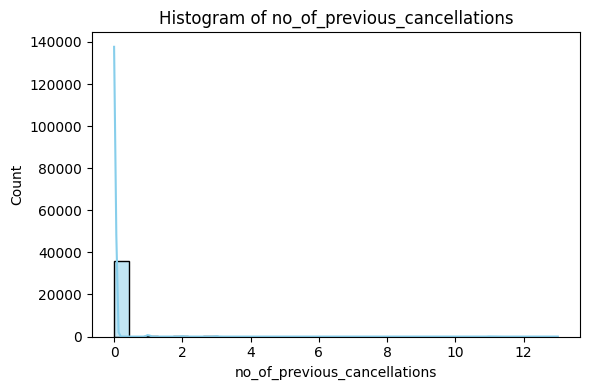

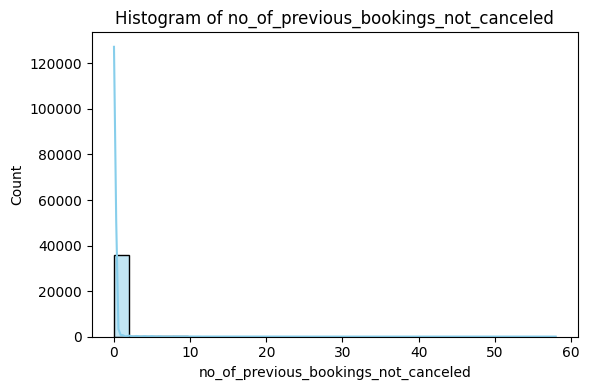

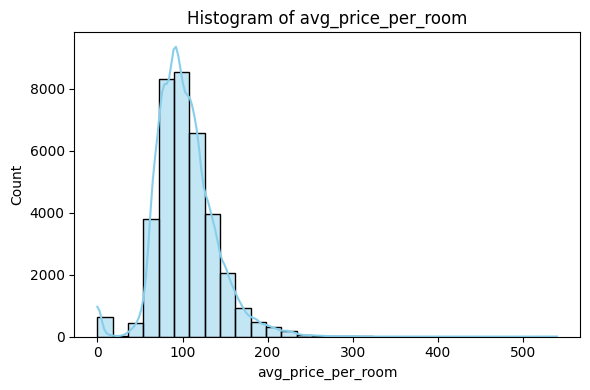

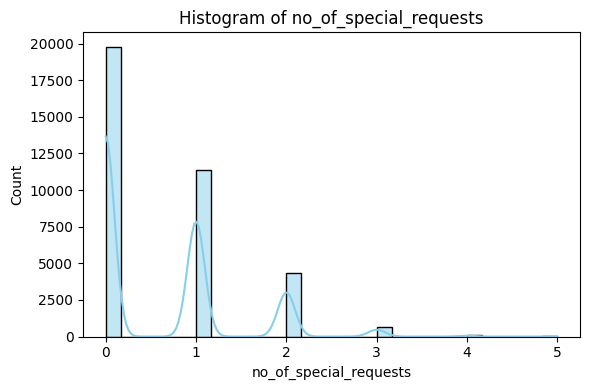

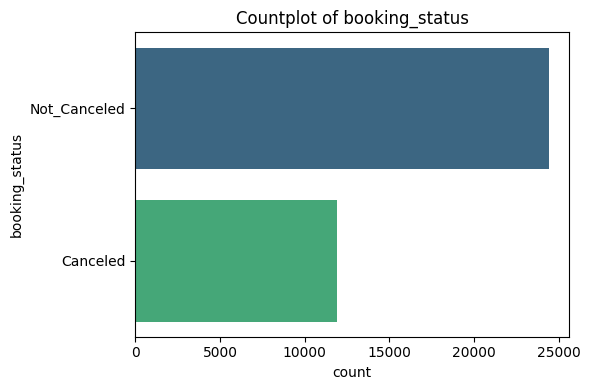

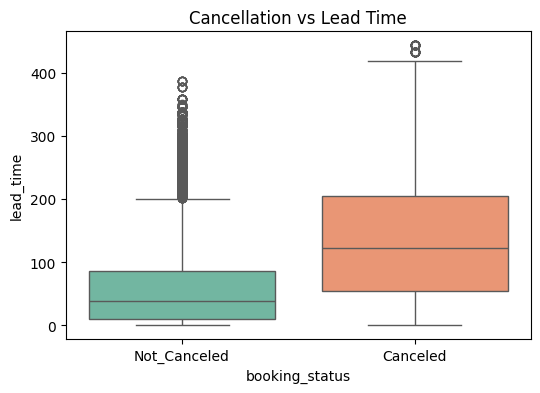

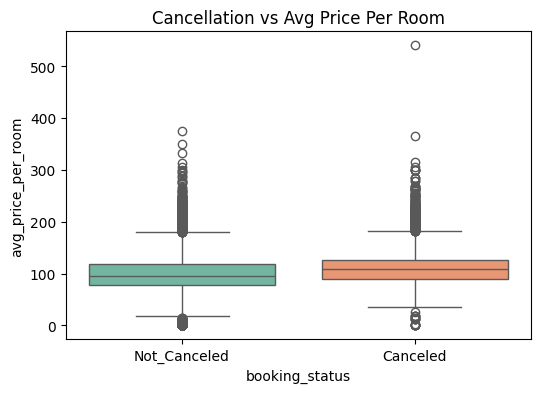

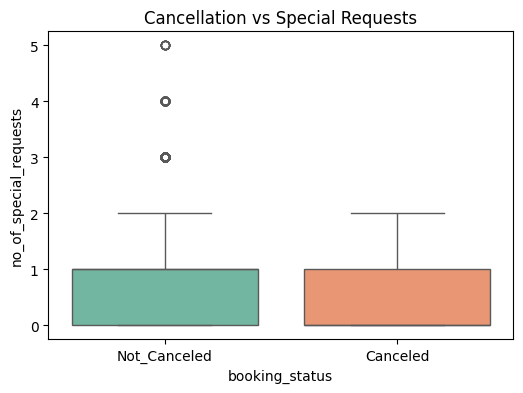

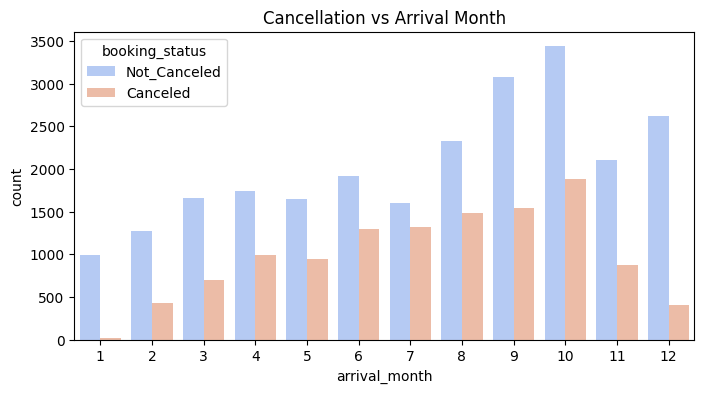

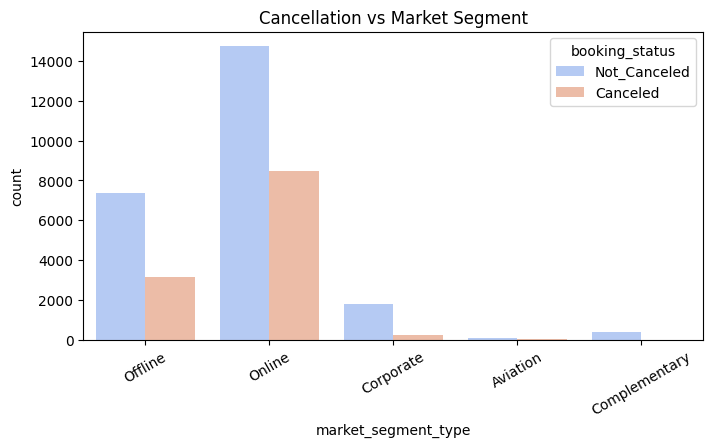

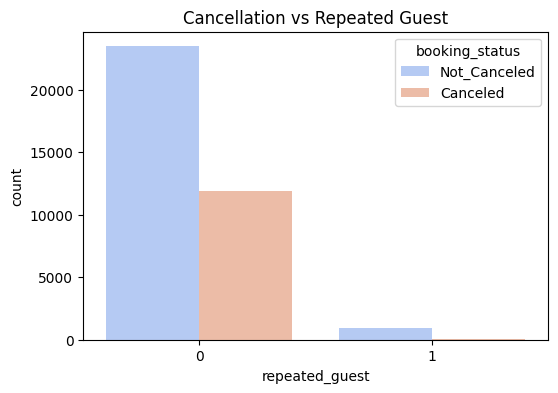

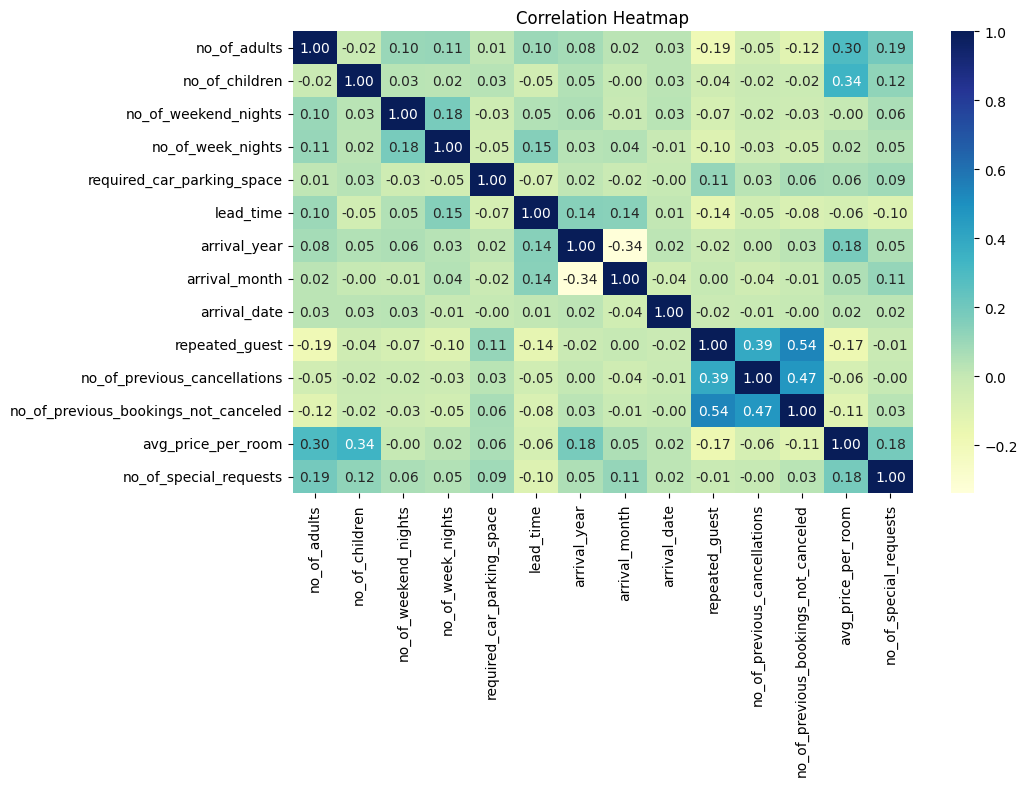

In [15]:
# EXPLORATORY DATA ANALYSIS (EDA)


# Univariate Analysis
for col in df.columns:
    plt.figure(figsize=(6,4))
    if df[col].dtype == 'object':  # categorical
        sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette="viridis")
        plt.title(f'Countplot of {col}')
    else:  # numeric
        sns.histplot(df[col], kde=True, bins=30, color="skyblue")
        plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()

# Bivariate Analysis
target = "booking_status"  # assuming this is the target column

# Cancellation rate vs lead_time
plt.figure(figsize=(6,4))
sns.boxplot(x=target, y="lead_time", data=df, palette="Set2")
plt.title("Cancellation vs Lead Time")
plt.show()

# Cancellation rate vs avg_price_per_room
plt.figure(figsize=(6,4))
sns.boxplot(x=target, y="avg_price_per_room", data=df, palette="Set2")
plt.title("Cancellation vs Avg Price Per Room")
plt.show()

# Cancellation rate vs no_of_special_requests
plt.figure(figsize=(6,4))
sns.boxplot(x=target, y="no_of_special_requests", data=df, palette="Set2")
plt.title("Cancellation vs Special Requests")
plt.show()

# Cancellation rate vs arrival_month (seasonality)
plt.figure(figsize=(8,4))
sns.countplot(x="arrival_month", hue=target, data=df, palette="coolwarm")
plt.title("Cancellation vs Arrival Month")
plt.show()

# Cancellation rate vs market_segment
plt.figure(figsize=(8,4))
sns.countplot(x="market_segment_type", hue=target, data=df, palette="coolwarm")
plt.title("Cancellation vs Market Segment")
plt.xticks(rotation=30)
plt.show()

# Cancellation rate vs repeated_guest
plt.figure(figsize=(6,4))
sns.countplot(x="repeated_guest", hue=target, data=df, palette="coolwarm")
plt.title("Cancellation vs Repeated Guest")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [16]:
# DATA PREPROCESSING

# Encode target variable
df["booking_status"] = df["booking_status"].map({"Not_Canceled": 0, "Canceled": 1})

# Convert categorical variables into dummies
df = pd.get_dummies(df, drop_first=True)

# Separate features & target
X = df.drop("booking_status", axis=1)
y = df["booking_status"]

# Scale continuous features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4878
           1       0.75      0.64      0.69      2377

    accuracy                           0.81      7255
   macro avg       0.80      0.77      0.78      7255
weighted avg       0.81      0.81      0.81      7255


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4878
           1       0.81      0.81      0.81      2377

    accuracy                           0.88      7255
   macro avg       0.86      0.86      0.86      7255
weighted avg       0.88      0.88      0.88      7255


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4878
           1       0.89      0.82      0.85      2377

    accuracy                           0.91      7255
   macro

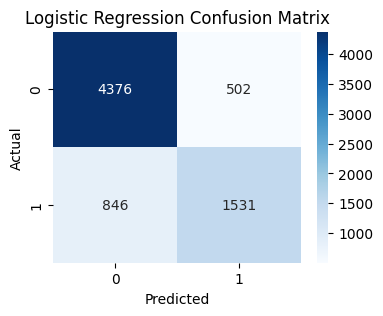

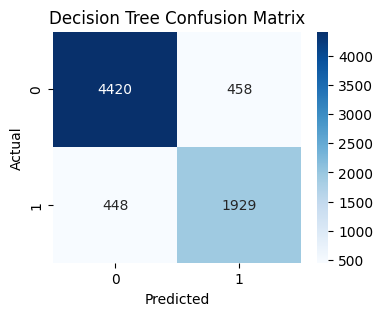

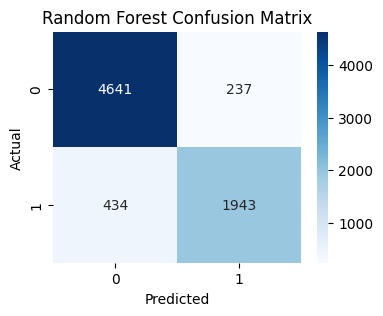

In [17]:
# BASELINE MODELING

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Show confusion matrices
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [18]:
# HYPERPARAMETER TUNING

# Random Forest tuning
rf_params = {'n_estimators':[100,200], 'max_depth':[None,10,20]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1')
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("\nBest RF Params:", rf_grid.best_params_)

# Logistic Regression tuning
log_params = {'C':[0.01,0.1,1,10], 'penalty':['l2']}
log_grid = GridSearchCV(LogisticRegression(max_iter=1000), log_params, cv=3, scoring='f1')
log_grid.fit(X_train, y_train)

best_log = log_grid.best_estimator_
print("\nBest LogReg Params:", log_grid.best_params_)


Best RF Params: {'max_depth': 20, 'n_estimators': 200}

Best LogReg Params: {'C': 10, 'penalty': 'l2'}


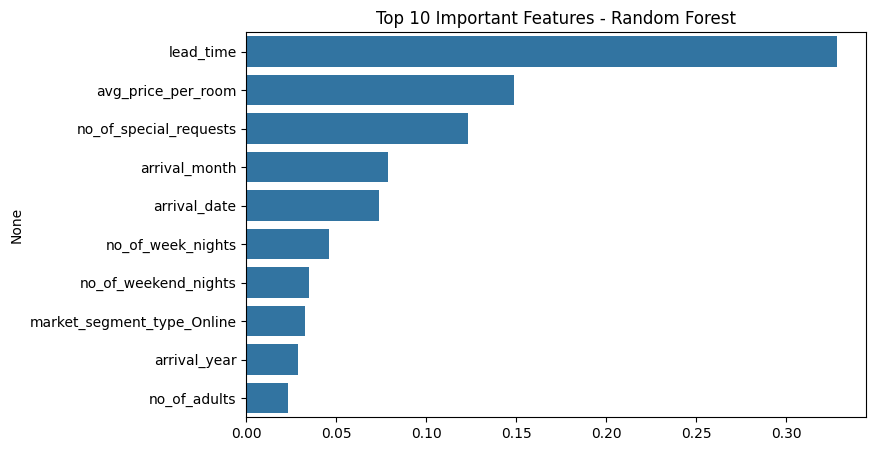

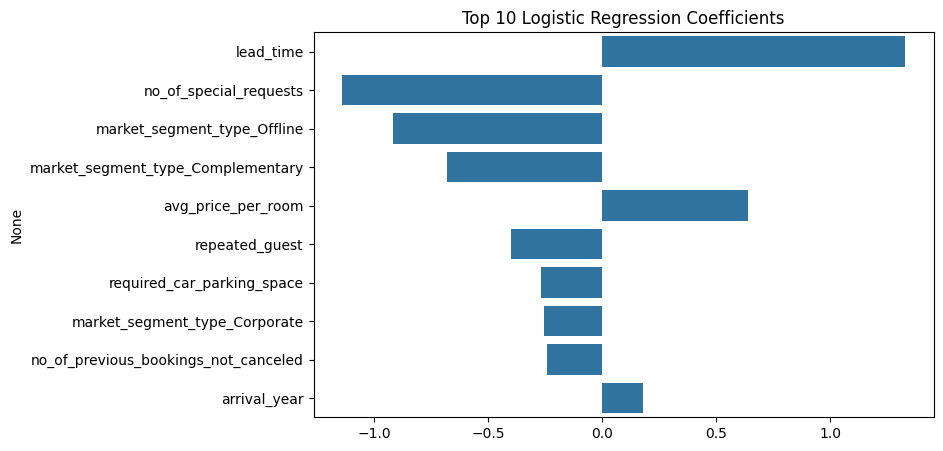

In [19]:
# FEATURE IMPORTANCE & INTERPRETATION

# Random Forest importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Top 10 Important Features - Random Forest")
plt.show()

# Logistic Regression coefficients
coeffs = pd.Series(best_log.coef_[0], index=X.columns)
coeffs = coeffs.sort_values(key=abs, ascending=False)[:10]

plt.figure(figsize=(8,5))
sns.barplot(x=coeffs.values, y=coeffs.index)
plt.title("Top 10 Logistic Regression Coefficients")
plt.show()

In [20]:
# SAVE ARTIFACTS
os.makedirs("artifacts", exist_ok=True)
joblib.dump(best_rf, "artifacts/best_model_rf.joblib")
joblib.dump(scaler, "artifacts/scaler.joblib")
# Save training columns after get_dummies
training_columns = X.columns
joblib.dump(training_columns, "artifacts/training_columns.pkl")

print("\nArtifacts saved in /artifacts folder")


Artifacts saved in /artifacts folder
